Перед AB-тестированием нужно проверить, что система сплитования работает корректно: CTR не отличается в экспериментальных группах.
Это позволит при AB-тестировании быть уверенными, что статистически значимые различия между экспериментальными группами
не связаны с тем, что в группах изначально были различия.

Итак, у нас есть данные АА-теста с '2022-01-07' по '2022-01-13'. Сделаем симуляцию, как будто мы провели 10000 АА-тестов. 
На каждой итерации будем сравнивать t-тестом (t-критерий Стьюдента) подвыборки по 500 юзеров из 2 и 3 экспериментальной группы. 


In [119]:
from CH import Getch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [120]:
query = '''
        select user_id, exp_group, 
        countIf(user_id, action = 'like') as likes, 
        countIf(user_id, action = 'view') as views, 
        likes / views as ctr
        from {db}.feed_actions
        where toDate(time) >= '2022-01-07' and  toDate(time) <= '2022-01-13'
        and exp_group in (2, 3)
        group by user_id, exp_group
        '''
df = Getch(query).df

In [121]:
df.head(5) # Исходные данные AA-теста

,user_id,exp_group,likes,views,ctr
0,115383,3,11,36,0.305556
1,123580,3,15,92,0.163043
2,131473,2,26,148,0.175676
3,23985,2,12,66,0.181818
4,24523,2,17,120,0.141667


In [122]:
# Функция для подсчета p-value в 10000 выборок и процента p-values, которые меньше или равны 0.05

def p_values_calculate(df1, df2, n_values = 500, tests_count = 10000):
    p_value = np.zeros(tests_count)
    p_val_less = 0
    for i in range(tests_count):
        df1_sample = df1.sample(n=n_values, replace=True)
        df2_sample = df2.sample(n=n_values, replace=True)
        p_value[i] = stats.ttest_ind(df1_sample, df2_sample).pvalue
        if p_value[i] <= 0.05:
            p_val_less += 1
    p_val_percent = np.round(p_val_less / tests_count * 100, 2)
    return p_value, p_val_percent

In [123]:
p_values, p_val_percent = p_values_calculate(df[df.exp_group == 2].ctr, df[df.exp_group == 3].ctr)

Text(3.799999999999997, 0.5, 'Количество t-тестов')

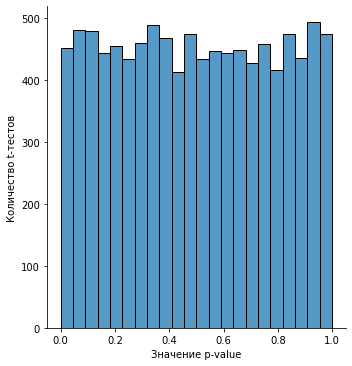

In [129]:
# Распределение p-values

sns.displot(p_values)
plt.xlabel('Значение p-value')
plt.ylabel('Количество t-тестов')

In [130]:
print('Процент t-тестов, в которых p-value оказался меньше или равен 0.05: ', p_val_percent, '%')

Процент t-тестов, в которых p-value оказался меньше или равен 0.05:  4.96 %


Лишь в 4.96% случаев нам удалось отклонить нулевую гипотезу о том, что значение признака CTR в двух группах не различается. 
Так как мы принимали нулевую гипотезу при условии, что p_value < 0.05, то эти ~ 5% соответствуют случайному ложному срабатыванию.

Следовательно, наша **система сплитования работает корректно**.